In [1]:
#move to Jupyter adroit machine

import numpy as np 
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from types import SimpleNamespace
from copy import deepcopy
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

In [2]:
with open('grid-host.csv', 'r') as f:
    lines = f.readlines()
    key_list = [key.strip('\n') for key in lines[0].split(',')]
    grid = {key: [] for key in key_list}
    for line in lines[1:]:
        line_split = line.split(",")
        for i, datum in enumerate(line_split):
            grid[key_list[i]].append(float(datum))

grid = {key: np.array(value) for (key, value) in grid.items()}
grid = SimpleNamespace(**grid)
grid.dx = 1 / 2**grid.L
grid.x = grid.i * grid.dx + grid.dx / 2
grid.y = grid.j * grid.dx + grid.dx / 2
grid.z = grid.k * grid.dx + grid.dx / 2
grid.r = np.sqrt((grid.x - 0.5)**2 + (grid.y - 0.5)**2 + (grid.z - 0.5)**2)


In [3]:
# check that leaf cells sum to unity
np.sum(grid.dx[grid.flag_leaf == 1]**3)


1.0

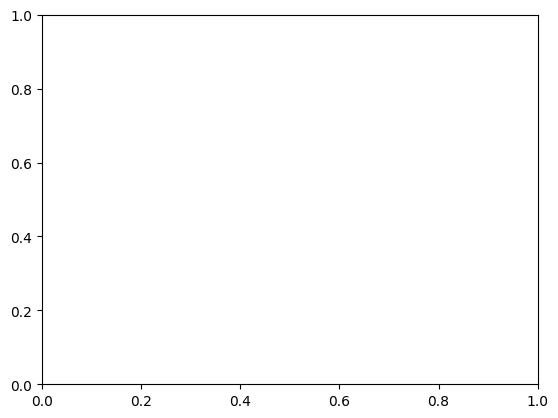

In [2]:
sigma = 0.001 #same as in .h file
def rho_func(x, y, z, x0=0.5, y0=0.5, z0=0.5, sigma=sigma):
    rsq = (x - x0)**2 + (y - y0)**2 + (z - z0)**2
    return np.exp(-rsq / (2 * sigma)) / np.sqrt(2 * np.pi * sigma**3)

def plot_rho_grad_slice(grid, z, L=[0, 1, 2], num=50, ax=plt.gca()):
    coord_min = grid.z - 1 / 2**(grid.L + 1)
    coord_max = grid.z + 1 / 2**(grid.L + 1)
    cond = (z >= coord_min) & (z <= coord_max)
    cond &= np.array(list(map(lambda x: x in L, grid.L)))
    x_grid, y_grid = np.meshgrid(np.linspace(0, 1, num), np.linspace(0, 1, num), indexing='ij')
    rho_grad_x_grid = griddata((grid.x[cond], grid.y[cond]), grid.rho_grad_x[cond], (x_grid, y_grid), fill_value=0)
    im = plt.contourf(x_grid, y_grid, rho_grad_x_grid, levels=200, vmin=min(grid.rho_grad_x), vmax=max(grid.rho_grad_x))
    return im, rho_grad_x_grid

def plot_rho_slice(grid, z, L=[0, 1, 2], num=50):
    coord_min = grid.z - 1 / 2**(grid.L + 1)
    coord_max = grid.z + 1 / 2**(grid.L + 1)
    cond = (z >= coord_min) & (z <= coord_max)
    cond &= np.array(list(map(lambda x: x in L, grid.L)))
    x_grid, y_grid = np.meshgrid(np.linspace(0, 1, num), np.linspace(0, 1, num), indexing='ij')
    rho_grid = griddata((grid.x[cond], grid.y[cond]), grid.rho[cond], (x_grid, y_grid), fill_value=0)
    im = plt.contourf(x_grid, y_grid, rho_grid, levels=200, vmin=min(grid.rho), vmax=max(grid.rho))
    return im

def plot_grid_slice(grid, z, color='black', L=[0, 1, 2]):
    coord_min = [coord - 1 / 2**(grid.L + 1) for coord in [grid.x, grid.y, grid.z]]
    coord_max = [coord + 1 / 2**(grid.L + 1) for coord in [grid.x, grid.y, grid.z]]
    cond = (z >= coord_min[2]) & (z <= coord_max[2])
    cond &= np.array(list(map(lambda x: x in L, grid.L)))
    plt.plot(np.array([coord_min[0][cond], coord_min[0][cond], coord_max[0][cond], coord_max[0][cond], coord_min[0][cond]]), \
             np.array([coord_min[1][cond], coord_max[1][cond], coord_max[1][cond], coord_min[1][cond], coord_min[1][cond]]), \
                color=color, lw=0.5)

In [5]:
try:
    plt_default_size
except:
    plt_default_size = plt.rcParams["figure.figsize"]
    
plt.rcParams["figure.figsize"] = [1.8 * i for i in deepcopy(plt_default_size)]
plt.show()
plt.close()

[6.0, 4.0]


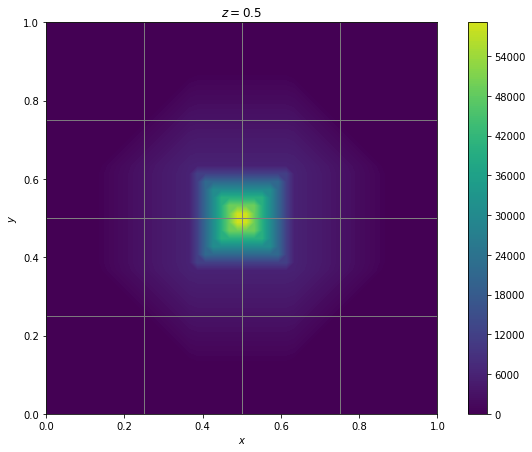

In [6]:
print(plt_default_size)
z = 0.5
im = plot_rho_slice(grid, z)
plot_grid_slice(grid, z, color='grey')

plt.rcParams["figure.figsize"] = [1.8 * i for i in deepcopy(plt_default_size)]
plt.gca().set_aspect(1.)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'$z = %.3g$' % z)
plt.colorbar()
plt.show()
plt.close()

In [7]:
grid.z[grid.L==1]
coord_min = grid.z - 1 / 2**(grid.L + 1)
coord_max = grid.z + 1 / 2**(grid.L + 1)
cond = (z >= coord_min[grid.L==1]) & (z <= coord_max[grid.L==1])
cond

array([ True,  True,  True,  True,  True,  True,  True,  True])

In [8]:
grid.L

array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 1., 2., 2., 2., 1., 2., 1., 2., 2., 2., 0., 2.,
       1., 2., 2., 2., 2., 1., 2., 2., 1., 2., 2., 2., 1., 2., 2., 2., 2.,
       2., 2., 1., 2., 2.])

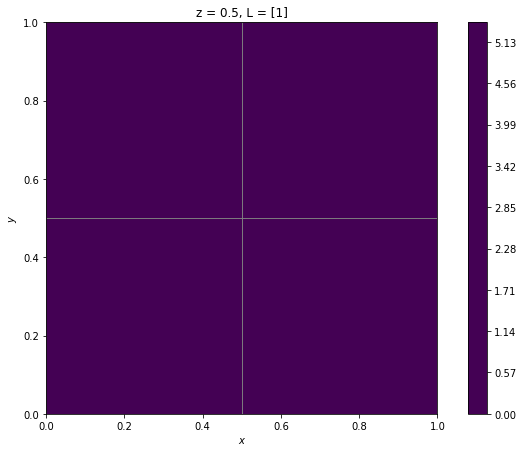

In [9]:
z = 0.5
L = [1]
im = plot_rho_slice(grid, z, L)
plot_grid_slice(grid, z, color='grey', L=L)

plt.gca().set_aspect(1.)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(f'z = {z}, L = {L}')
plt.colorbar()
plt.show()
plt.close()

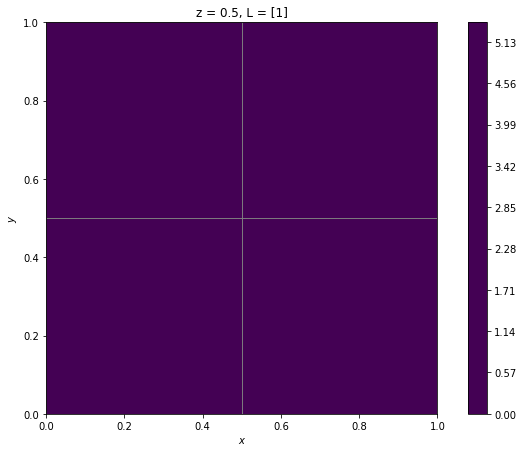

In [10]:
z = 0.5
L = [1]
im = plot_rho_slice(grid, z, L)
plot_grid_slice(grid, z, color='grey', L=L)

plt.gca().set_aspect(1.)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(f'z = {z}, L = {L}')
plt.colorbar()
plt.show()
plt.close()

In [11]:
#data check
with open('run_2024-03-18_14h34.log', 'r') as file:
    data = file.read()
data = data.split('\n')

host_data, gpu_data = set(), set()
for i in range(len(data)):
    if data[i].startswith('HOST ['):
        host_data.add(data[i][5:])
    if data[i].startswith('GPU ['):
        gpu_data.add(data[i][4:])
assert host_data == gpu_data



In [1]:
!pip3 install matplotlib

/bin/bash: pip3: command not found


In [2]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from types import SimpleNamespace
from copy import deepcopy

ModuleNotFoundError: No module named 'matplotlib'

In [13]:
with open('grid-device.csv', 'r') as f:
    lines = f.readlines()
    key_list = [key.strip('\n') for key in lines[0].split(',')]
    grid_dev = {key: [] for key in key_list}
    for line in lines[1:]:
        line_split = line.split(",")
        for i, datum in enumerate(line_split):
            grid_dev[key_list[i]].append(float(datum))

grid_dev = {key: np.array(value) for (key, value) in grid_dev.items()}
grid_dev = SimpleNamespace(**grid_dev)
grid_dev.dx = 1 / 2**grid_dev.L
grid_dev.x = grid_dev.i * grid_dev.dx + grid_dev.dx / 2
grid_dev.y = grid_dev.j * grid_dev.dx + grid_dev.dx / 2
grid_dev.z = grid_dev.k * grid_dev.dx + grid_dev.dx / 2
grid_dev.r = np.sqrt((grid_dev.x - 0.5)**2 + (grid_dev.y - 0.5)**2 + (grid_dev.z - 0.5)**2)

np.sum(grid_dev.dx[grid_dev.flag_leaf == 1]**3)

1.0

[6.0, 4.0]


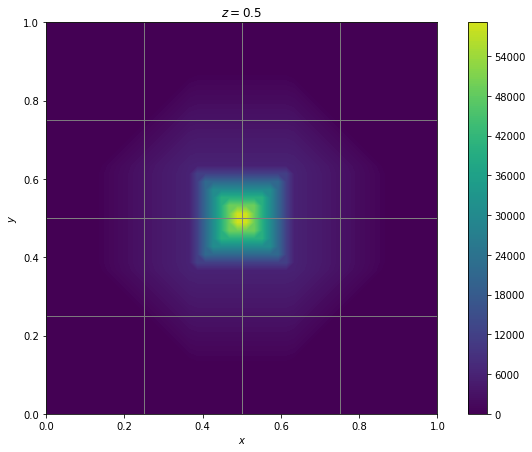

In [14]:
print(plt_default_size)
z = 0.5
im = plot_rho_slice(grid_dev, z)
plot_grid_slice(grid_dev, z, color='grey')

plt.rcParams["figure.figsize"] = [1.8 * i for i in deepcopy(plt_default_size)]
plt.gca().set_aspect(1.)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'$z = %.3g$' % z)
plt.colorbar()
plt.show()
plt.close()

[6.0, 4.0]
[False False  True  True False False  True  True False  True False  True
  True  True False  True False  True False  True  True  True  True False
 False False False False False  True False  True False False  True  True
 False  True False  True False  True False  True  True  True  True False
 False  True False  True  True  True False False  True False False  True
  True  True  True  True  True False  True  True False  True  True False
  True]
[-1.21631e+04 -2.34803e+01 -2.82005e+01 -1.46082e+04 -1.21631e+04
 -2.34803e+01 -2.82005e+01 -1.46082e+04 -1.46082e+04 -2.82005e+01
 -1.21631e+04 -2.34803e+01 -2.82005e+01 -1.46082e+04 -1.21631e+04
 -2.34803e+01  1.21631e+04  2.34803e+01  2.82005e+01 -2.87222e+00
  2.34803e+01  2.87222e+00  1.46082e+04  2.87222e+00  2.82005e+01
  0.00000e+00  2.87222e+00  2.82005e+01  1.21631e+04 -2.87222e+00
 -2.87222e+00  2.34803e+01  1.21631e+04  1.46082e+04  2.87222e+00
  2.82005e+01  1.46082e+04  1.21631e+04  2.34803e+01 -2.87222e+00
  1.46082e+04]


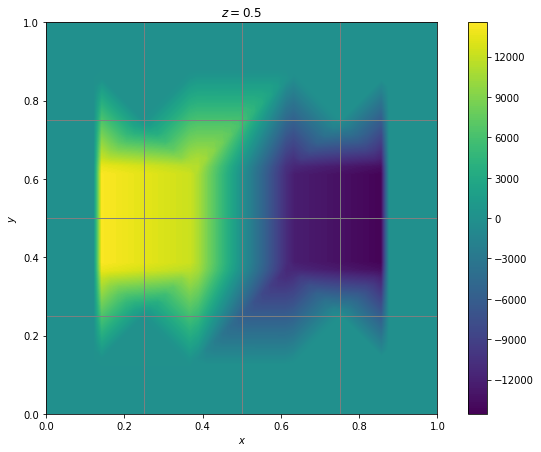

In [15]:
print(plt_default_size)
z = 0.5
im = plot_rho_grad_slice(grid_dev, z)
plot_grid_slice(grid_dev, z, color='grey')

plt.rcParams["figure.figsize"] = [1.8 * i for i in deepcopy(plt_default_size)]
plt.gca().set_aspect(1.)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'$z = %.3g$' % z)
plt.colorbar()
plt.show()
plt.close()

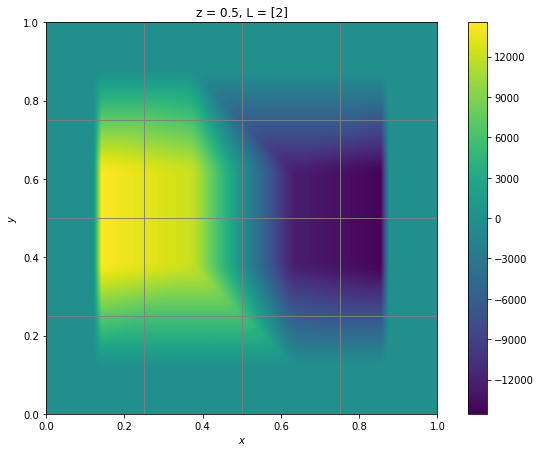

: 

In [22]:
z = 0.5
L = [2]
im = plot_rho_grad_slice(grid_dev, z, L)
plot_grid_slice(grid_dev, z, color='grey', L=L)

plt.gca().set_aspect(1.)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(f'z = {z}, L = {L}')
plt.colorbar()
plt.show()
plt.close()

In [5]:
with open('grid-device-matrix.csv', 'r') as f:
    lines = f.readlines()
    key_list = [key.strip('\n') for key in lines[0].split(',')]
    grid_dev_mat = {key: [] for key in key_list}
    for line in lines[1:]:
        line_split = line.split(",")
        for i, datum in enumerate(line_split):
            grid_dev_mat[key_list[i]].append(float(datum))

grid_dev_mat = {key: np.array(value) for (key, value) in grid_dev_mat.items()}
grid_dev_mat = SimpleNamespace(**grid_dev_mat)
grid_dev_mat.dx = 1 / 2**grid_dev_mat.L
grid_dev_mat.x = grid_dev_mat.i * grid_dev_mat.dx + grid_dev_mat.dx / 2
grid_dev_mat.y = grid_dev_mat.j * grid_dev_mat.dx + grid_dev_mat.dx / 2
grid_dev_mat.z = grid_dev_mat.k * grid_dev_mat.dx + grid_dev_mat.dx / 2
grid_dev_mat.r = np.sqrt((grid_dev_mat.x - 0.5)**2 + (grid_dev_mat.y - 0.5)**2 + (grid_dev_mat.z - 0.5)**2)

#np.sum(grid_dev_mat.dx[grid_dev_mat.flag_leaf == 1]**3)

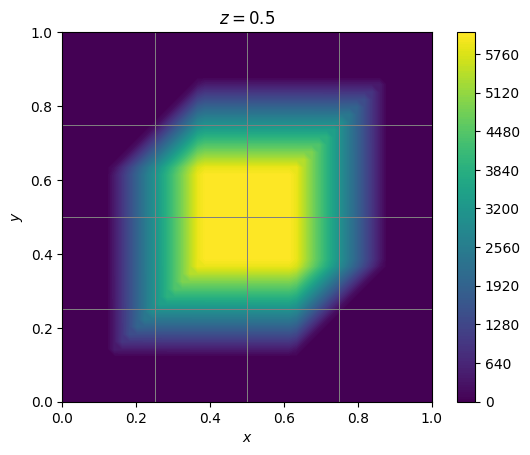

In [9]:
#print(plt_default_size)
z = 0.5
im = plot_rho_slice(grid_dev_mat, z)
plot_grid_slice(grid_dev_mat, z, color='grey')

#plt.rcParams["figure.figsize"] = [1.8 * i for i in deepcopy(plt_default_size)]
plt.gca().set_aspect(1.)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'$z = %.3g$' % z)
plt.colorbar()
plt.show()
plt.close()

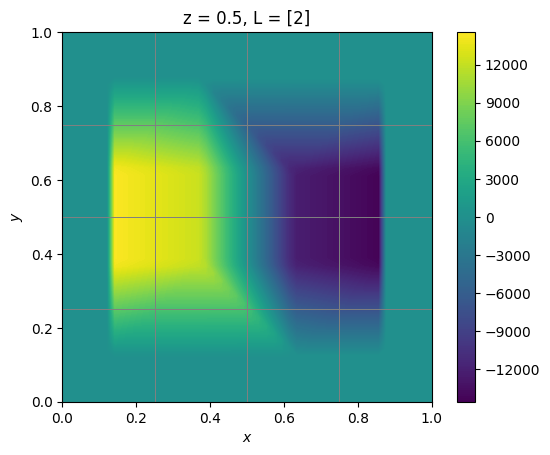

In [10]:
z = 0.5
L = [2]
im = plot_rho_grad_slice(grid_dev_mat, z, L)
plot_grid_slice(grid_dev_mat, z, color='grey', L=L)

plt.gca().set_aspect(1.)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(f'z = {z}, L = {L}')
plt.colorbar()
plt.show()
plt.close()